In [5]:
import Tools 
import pyfits, healpy
reload(Tools)
from scipy.integrate import quad 
from scipy.special import expn
import numpy as np 
import matplotlib.pyplot as plt
import sys 


def GetSpec(specType):
    '''
    Given a 2FGL Spectral type return lambdas for the spectrum and integrated spectrum
    params:
        specType: Can be 'PowerLaw','PLExpCutoff', or 'LogParabola' 
    returns: 
        Spec,IntegratedSpec: the spectrum and integrated spectrum.  See function def for param ordering. 
    '''
    if specType == 'PowerLaw':
        Spec           = lambda e,gamma: e**-gamma
        IntegratedSpec = lambda e1,e2,gamma: (e1*e2)**-gamma * (e1*e2**gamma - e1**gamma*e2)/ (gamma-1)

    elif specType == 'PLExpCutoff':
        Spec           = lambda e,gamma,cutoff: e**-gamma * np.exp(-e/cutoff)
        IntegratedSpec = lambda e1,e2,gamma,cutoff: e1**(1-gamma)*expn(gamma,e1/cutoff)-e2**(1-gamma)*expn(gamma,e2/cutoff)

    elif specType== 'LogParabola':
        Spec           = lambda e, alpha, beta, pivot: e**-(alpha+beta*np.log(e/pivot))
        IntegratedSpec = lambda e1,e2,alpha,beta,pivot: quad(Spec,e1,e2,args=(alpha,beta,pivot))[0]
    else:
        raise Exception("Spectral type not supported.")
    
    return Spec, IntegratedSpec
    


def GenSourceMap(bin_edges,l_range=[-180,180],b_range=[-45,45], 
                 fglpath='/data/gll_psc_v08.fit',
                 expcube='/data/fermi_data_1-8-14/gtexpcube2_ALL_BOTH',
                 psfFile='/data/fermi_data_1-8-14/psf_P7REP_SOURCE_BOTH.fits',
                 maxPSF = 5.,
                 res=0.125,
                 nside=256,
                 onlyidx=None):
    '''
    This method generates a source map based on an input catalog implementing the following procedure:
    1. Integrate given spectrum to 2FGL over each energy bin to obtain counts/cm^2/s
    2. Multiply  by effective exposure to obtain counts
    3. Convolve with PSF to obtain the source map.
    '''
    # Load FGL cat
    fgl_data = pyfits.open(fglpath)[1].data
    # Init the master point source template
    PSCMap = np.zeros(shape=(len(bin_edges)-1,12*nside**2))
    
    # Determine which sources are inside the spatial window. 
    idx_all = np.where(  (fgl_data['GLAT']<b_range[1]) & (fgl_data['GLAT']>b_range[0])
                       & ( (fgl_data['GLON']<l_range[1]) | (fgl_data['GLON']>(l_range[0]+360)) ))[0]
    
    #idx_all = np.where(  (fgl_data['GLAT']<b_range[1]) & (fgl_data['GLAT']>b_range[0])
    #                      & (fgl_data['GLON']>350))[0]
    
    
    # Pre-load all the point spread functions as a function of fine energy binning so we can reweight against spectra.
    hdu = pyfits.open(psfFile)
    
    thetas   = np.array([theta[0] for theta in hdu[2].data])
    
    energies = np.array([energy[0] for energy in hdu[1].data])
    PSFs     = np.array([psf[2] for psf in hdu[1].data])
    
    # Iterate over sources 
    for i_idx, idx in enumerate(idx_all):
        
        # Debug
        if onlyidx!=None:
            if (i_idx not in onlyidx):continue
        
        #-----------------------------------------------------------
        # First we determine the number of counts.
        
        # Retreive the spectrum and integrated spectrum functions
        specType = fgl_data['SpectrumType'][idx]
        spec, IntegratedSpec = GetSpec(specType)
        
        # Get the spectral parameters
        specIndex = fgl_data['Spectral_Index'][idx]
        beta      = fgl_data['beta'][idx]
        fluxDens  = fgl_data['Flux_Density'][idx]
        pivot     = fgl_data['Pivot_Energy'][idx]
        cutoff    = fgl_data['Cutoff'][idx]
        glat = fgl_data['GLAT'][idx]
        glon = fgl_data['GLON'][idx]
        
        # Find the Normalization and integrate the spectrum over each energy bin
        if specType == 'PowerLaw':
            norm = fluxDens/spec(pivot,specIndex)
            counts = norm*np.array([IntegratedSpec(bin_edges[i_E],bin_edges[i_E+1],specIndex) for i_E in range(len(bin_edges)-1)])            
            psfWeights = spec(energies,specIndex)            
            
        elif specType == 'PLExpCutoff':
            norm = fluxDens/spec(pivot,specIndex,cutoff)
            counts = norm*np.array([IntegratedSpec(bin_edges[i_E],bin_edges[i_E+1],specIndex,cutoff) for i_E in range(len(bin_edges)-1)])                
            psfWeights = spec(energies,specIndex,cutoff)
        elif specType== 'LogParabola':
            norm = fluxDens/spec(pivot,specIndex,beta,pivot)
            counts = norm*np.array([IntegratedSpec(bin_edges[i_E],bin_edges[i_E+1],specIndex,beta,pivot) for i_E in range(len(bin_edges)-1)])
            psfWeights = spec(energies,specIndex,beta,pivot)
        
        # Now counts contains ph/cm^2/s^2 for each bin so we need to get the effective area in each bin. 
        exposure = np.array([Tools.GetExpMap(bin_edges[i_E],bin_edges[i_E+1],glon,glat,expcube) for i_E in range(len(bin_edges)-1)]) 
        # Now the counts are in actual counts
        counts = counts*exposure
        
        #-----------------------------------------------------------
        # Apply PSF
        avgPSF = [] 
        size = 2*maxPSF/res+1
        lats, lons = np.linspace(-maxPSF,maxPSF,size), np.linspace(-maxPSF,maxPSF,size)
        
        
        # Calculate the reweighted PSF in each energy bin for this source's spectrum.
        for i_E in range(len(bin_edges)-1):
            e1,e2 = bin_edges[i_E],bin_edges[i_E+1]
            eb1, eb2 = np.argmin(np.abs(energies-e1)), np.argmin(np.abs(energies-e2))
            avgPSF = np.average(PSFs[eb1:eb2],weights=psfWeights[eb1:eb2],axis=0)
            avgPSFInterp = lambda r: np.interp(r,thetas,avgPSF)
            
            # Form a cartesian array for this PSF which will be mapped to the healpix grid
            cartMap = np.zeros(shape=(size,size))
            
            # Scan over latitudes and fill in PSF value 
            for i_lat, lat in enumerate(lats):
                # Now calculate distances for each point 
                r = np.sqrt(lat**2+lons**2)
                cartMap[i_lat,:] = avgPSFInterp(r)# *res**2*(np.pi/180.)**2
            
            # Mult by solid angle/px and sum gives ~1. Good! 
            # We will just renormalize sum to 1 since there is a small error
            cartMap = cartMap/cartMap.sum()*counts[i_E] # Now units are photons falling in that pixel. 
            
            # Now we need to map this grid onto the healpix grid. 
            for i_lat, lat in enumerate(lats):
                realLat = glat+lat 
                # If we crossed the pole, also flip the meridian. 
                # TODO FIX BEHAVIOR NEAR POLES Currently not handled correctly
                # A GOOD WAY TO DO THIS WOULD BE TO USE THE GAMMACAP CODE WHICH 
                # ROTATES A GIVEN INITIAL POSITION UP TO A SKYMAP POSITION. 
                if realLat > 90.: realLat-=90.
                if realLat < -90.: realLat+=90.
                if glon>180: glon-=360.
                # Take care of rescaling the effective longitude based on the latitude.
                # longitude doesn't really matter if we are right a N/S pole.
                #if np.abs(90-np.abs(realLat))>.125: new_lons = ((glon+lons)/np.cos(np.deg2rad(realLat)))%360
                new_lons = (glon+lons/np.cos(np.deg2rad(realLat)))%360
                # Find the which hpix bin each pixel falls and add the counts
                hpix_idx = Tools.ang2hpix(new_lons,realLat,nside=nside)
                # Add the values to the healpix grid.  Must use this 'at' method in order to
                # correctly add repeated indices.
                np.add.at(PSCMap[i_E],hpix_idx,cartMap[i_lat])
            #print cartMap.sum()
        
        
        if i_idx%1==0:
            print '\rFraction Complete:', '%.3f' % (np.float(i_idx)/len(idx_all)),
            sys.stdout.flush()
            
    return PSCMap
    
    
    
    
    
    #---------------------------------------------------
    # Integrate the source spectrum 
    
    
bin_edges=[300, 350, 400, 450, 500, 557.4511962326, 624.9931144482831, 705.0811841511901, 800.9547380631948, 916.9544789959854, 1058.9994895010252, 1235.32183584898, 1457.6298200740125, 1743.0094229290717, 2117.148088832825, 2620.038055486477, 3316.5858204132596, 4317.5724796525965, 5824.226374320851, 8232.171915073328, 12404.648624640446, 20517.115667189668, 39361.808463774716, 99337.18520898951, 499999.9999999654]
cmap = GenSourceMap(bin_edges,onlyidx=None)

Fraction Complete: 0.999


/home/carlson/ipython/IPython/kernel/__main__.py:25: RuntimeWarning: floating point number truncated to an integer


/home/carlson/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/home/carlson/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10
/home/carlson/anaconda/lib/python2.7/site-packages/healpy/pixelfunc.py:252: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


Populating the interactive namespace from numpy and matplotlib


/home/carlson/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2193: RuntimeWarning: invalid value encountered in less_equal
  condition = umath.less_equal(mabs(xnew - value), atol + rtol * mabs(value))
/home/carlson/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:993: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/carlson/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:994: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


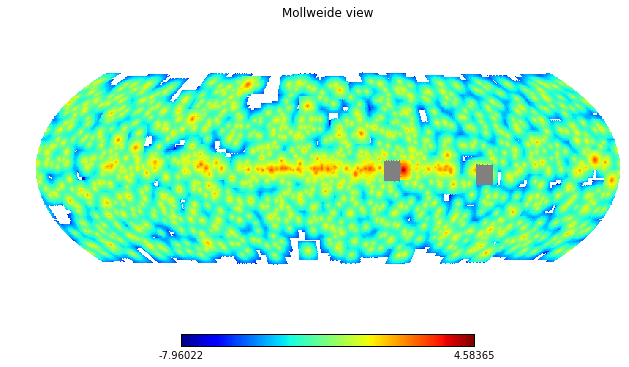

In [6]:
%pylab inline
import healpy
#hdu=pyfits.open ('/data/fermi_data_1-8-14/gtexpcube2_ALL_BOTH')
#print hdu[0].header.cards
#print hdu[0].data.max()


#healpy.mollview(np.log10())
#healpy.mollview((np.log10(A.binned_data[10])))
healpy.mollview(np.log10(cmap[10]))
plt.show()

In [13]:
print (2.44972e+11/800)/3.15e7

9.72111111111


In [106]:
import Analysis
reload(Analysis)
A = Analysis.Analysis()
A.BinPhotons()

In [42]:
def GetSpec(specType):
    if specType == 'PowerLaw':
        Spec = lambda e,gamma: e**-gamma
        IntegratedSpec = lambda e1,e2,gamma: (e1*e2)**-gamma * (e1*e2**gamma - e1**gamma*e2)/ (gamma-1)

    if specType == 'PLExpCutoff':
        Spec = lambda e,gamma,cutoff: e**-gamma * np.exp(-e/cutoff)
        IntegratedSpec = lambda e1,e2,gamma,cutoff: e1**(1-gamma)*expn(gamma,e1/cutoff)-e2**(1-gamma)*expn(gamma,e2/cutoff)

    if specType== 'LogParabola':
        Spec = lambda e, alpha, beta, pivot: e**-(alpha+beta*np.log(e/pivot))
        IntegratedSpec = lambda e1,e2,alpha,beta,pivot: quad(Spec,e1,e2,args=(alpha,beta,pivot))[0]
    
    return Spec, IntegratedSpec
    

spec, IntegratedSpec = GetSpec(specType='PowerLaw')
print IntegratedSpec(100,1e5,2)

spec, IntegratedSpec = GetSpec(specType='PLExpCutoff')
print IntegratedSpec(100,1e5,2,1e3)
    
spec, IntegratedSpec = GetSpec(specType='LogParabola')
print IntegratedSpec(100,1e5,2,1,1e3)

0.00999
0.00722545022194
106.563916698


In [28]:
pyfits.open('bubble_templates_diskcut30.0.fits')[1].header.cards

('XTENSION', 'BINTABLE', 'Binary table written by MWRFITS v1.8')
('BITPIX', 8, 'Required value')
('NAXIS', 2, 'Required value')
('NAXIS1', 3145770, 'Number of bytes per row')
('NAXIS2', 25, 'Number of rows')
('PCOUNT', 0, 'Normally 0 (no varying arrays)')
('GCOUNT', 1, 'Required value')
('TFIELDS', 5, 'Number of columns in table')
('COMMENT', '', '')
('COMMENT', ' *** End of mandatory fields ***', '')
('COMMENT', '', '')
('COMMENT', '', '')
('COMMENT', ' *** Column names ***', '')
('COMMENT', '', '')
('TTYPE1', 'NAME', '')
('TTYPE2', 'COLOR', '')
('TTYPE3', 'LINESTYLE', '')
('TTYPE4', 'NORMFIX', '')
('TTYPE5', 'TEMPLATE', '')
('COMMENT', '', '')
('COMMENT', ' *** Column formats ***', '')
('COMMENT', '', '')
('TFORM1', '26A', '')
('TFORM2', '11A', '')
('TFORM3', 'J', '')
('TFORM4', 'B', '')
('TFORM5', '786432E', '')

In [39]:
import numpy as np
np.sqrt(3145770/12)

512.0029296791181